<h3 style="text-align:center"> <b>Formula 1</b> Data Analysis </h3>

Version 1.0.0  
Author: [Dorian ROUX](https://rouxdorian.com)  
Estimated Runtime: < 2 minutes. 
 
---- 

#### Libraries

In [1]:
# - Import Libraries - 
import datetime
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import itertools
import math

#### Functions

In [2]:
# - Update a dictionnary - #
def updateDictionnary(inputDict: dict, outputDict: dict, inputKeys: list, outputKeys: list):
    """Update a dictionnary by adding a new key and value based on the existance of the inputKeys within the inputDict.
    Args:
        inputDict (dict): the input dictionnary.
        outputDict (dict): the output dictionnary.
        inputKeys (list): the list of keys to look for in the inputDict.
        outputKeys (list): the list of keys to add in the outputDict depending on the inputKeys.
    """    
    for i_, inputKey in enumerate(inputKeys):
        if inputKey in inputDict.keys():
            outputDict[outputKeys[i_]] = inputDict[inputKey]
    return outputDict

# - Transform an Integer into a String based on the "," separator - #
def transformInteger_intoStr(value: int):
    """Transform an integer into a string with commas for thousands separators.
    Args:
        value (int): the integer to transform.
    Returns:
        str: the string with commas for thousands separators.
    """    
    # Convert the integer value to a string with commas for thousands separators
    formatted_value = "{:,}".format(value)
    return formatted_value

# - Export a dictionnary as a JSON file - #
def exportJSON(dictContent: dict, filePath: str):
    """Export a dictionnary as a JSON file.
    Args:
        dictContent (dict): the dictionary to export.
        filePath (str): the path where to export the file.
    """    
    if not os.path.exists(os.path.dirname(filePath)):
        os.makedirs(os.path.dirname(filePath), exist_ok=True)
    with open(filePath, 'w') as fp:
        json.dump(dictContent, fp, indent=4)

# - Export a DataFrame as a CSV file - #
def exportCSV(df: pd.DataFrame, filePath: str):
    """Export a DataFrame as a CSV file.
    Args:
        df (pd.DataFrame): the DataFrame to export.
        filePath (str): the path where to export the file.
    """    
    if not os.path.exists(os.path.dirname(filePath)):
        os.makedirs(os.path.dirname(filePath), exist_ok=True)
    df.to_csv(filePath, index=False)

#### Core

- Races, Seasons, Drivers, Constructors Wins since 1950 
- Wins and Wins% per Drivers since 1950
- Laps Led per Drivers since 1950

In [3]:
# Data Folder
dataFolder = '../data'
dataProcessedFolder = os.path.join(dataFolder, 'processed')
dataPrscImagesFolder = os.path.join(dataProcessedFolder, 'images')

# Load the data
dictF1 = json.load(open(os.path.join(dataFolder, 'formula1-data.json'), 'r'))

# We do not take into account the current Season equivalent to CURRENT YEAR
del dictF1[(str(datetime.datetime.now().year))]

##### 1) Races, Seasons, Drivers, Constructors Wins since 1950

In [4]:
df_winners = pd.DataFrame() # Initialize the output dataframe
for seasonKey in dictF1.keys():  # Loop through each F1 Season
    for raceRoundKey in dictF1[seasonKey]['RACES']: # Loop through each Season Race
        if raceRoundKey in dictF1[seasonKey]['RESULTS']: # Verify whether the Race has a result (for instance a race in the future does not have a result yet)
            raceResult = dictF1[seasonKey]['RESULTS'][raceRoundKey]
            df_race = pd.DataFrame([{'SEASON': int(seasonKey), 'ROUND': int(raceRoundKey), 
                                     'RACE_NAME': dictF1[seasonKey]['RACES'][raceRoundKey]['RACE']['NAME'], 
                                     'CONSTRUCTOR': dictF1[seasonKey]['CONSTRUCTORS'][raceResult['1']['CONSTRUCTOR_ID']]['NAME'],
                                     'WINNER':  f"{dictF1[seasonKey]['DRIVERS'][raceResult['1']['DRIVER_ID']]['FIRST_NAME']} {dictF1[seasonKey]['DRIVERS'][raceResult['1']['DRIVER_ID']]['LAST_NAME']}",
                                     'GRID_POSITION': raceResult['1']['GRID_POSITION'], 'TIME': raceResult['1']['TIME']['time'],
                                     }])
            df_winners = pd.concat([df_winners, df_race], axis=0)
df_winners = df_winners.sort_values(by=['SEASON', 'ROUND']).reset_index(drop=True)
df_winners.sample(5)

,SEASON,ROUND,RACE_NAME,CONSTRUCTOR,WINNER,GRID_POSITION,TIME
281,1977,2,Brazilian Grand Prix,Ferrari,Carlos Reutemann,2,1:45:07.72
766,2006,17,Japanese Grand Prix,Renault,Fernando Alonso,5,1:23:52.413
671,2001,9,European Grand Prix,Ferrari,Michael Schumacher,1,1:29:42.724
774,2007,7,United States Grand Prix,McLaren,Lewis Hamilton,1,1:31:09.965
954,2016,20,Brazilian Grand Prix,Mercedes,Lewis Hamilton,1,3:01:01.335


In [5]:
# Export the Data
pathFile = os.path.join(dataProcessedFolder, 'race-winners-drivers-constructors.csv')
exportCSV(df_winners, pathFile)

In [6]:
# Display Information
averageYear = 1990
print(f"Total Races: {df_winners.shape[0]}")
print(f"Total Seasons: {df_winners['SEASON'].nunique()}")
print(f"Average Races per Season (Before {averageYear}): {round(df_winners[df_winners['SEASON'] < averageYear].shape[0] / df_winners[df_winners['SEASON'] < averageYear]['SEASON'].nunique())}")
print(f"Average Races per Season (After {averageYear}): {round(df_winners[df_winners['SEASON'] >= averageYear].shape[0] / df_winners[df_winners['SEASON'] >= averageYear]['SEASON'].nunique())}")
print(f"Total Constructors Winners: {df_winners['CONSTRUCTOR'].nunique()}")
print(f"Total Drivers Winners: {df_winners['WINNER'].nunique()}")

Total Races: 1101
Total Seasons: 74
Average Races per Season (Before 1990): 12
Average Races per Season (After 1990): 18
Total Constructors Winners: 47
Total Drivers Winners: 111


##### 2) Wins and Wins% per Drivers since 1950

In [7]:
# Transform the DataFrame
df_winners.rename(columns={"WINNER": "DRIVER"}, inplace=True)
df_winners['WINS'] = df_winners.groupby('DRIVER')['DRIVER'].transform('count')
df_winners.sort_values(by=['WINS'], ascending=False, inplace=True)
df_total_wins = df_winners[['DRIVER', 'WINS']].drop_duplicates().reset_index(drop=True)

rank = 1
lsRank = []
for index, row in df_total_wins.iterrows():
    if (index > 0 and row['WINS'] != df_total_wins.iloc[index - 1]['WINS']):
        rank += 1
    lsRank.append(rank)
df_total_wins['RANK'] = lsRank
df_total_wins.head(10)

,DRIVER,WINS,RANK
0,Lewis Hamilton,103,1
1,Michael Schumacher,91,2
2,Max Verstappen,54,3
3,Sebastian Vettel,53,4
4,Alain Prost,51,5
5,Ayrton Senna,41,6
6,Fernando Alonso,32,7
7,Nigel Mansell,31,8
8,Jackie Stewart,27,9
9,Jim Clark,25,10


Implement additionnal information like the following:
- Number of Seasons
- Number of Races
- Percentage of Wins

In [8]:
dictDrivers = {driverFullName: {'RACES': [], 'SEASONS': [], 'WINS': df_total_wins[df_total_wins.DRIVER == driverFullName].WINS.iloc[0]} for driverFullName in df_total_wins['DRIVER'].unique()}

df_drivers_races = pd.DataFrame() # Initialize the output dataframe
for seasonKey in dictF1.keys():  # Loop through each F1 Season
    for raceRoundKey in dictF1[seasonKey]['RACES']: # Loop through each Season Race
        if raceRoundKey in dictF1[seasonKey]['RESULTS']: # Verify whether the Race has a result (for instance a race in the future does not have a result yet)
            raceResult = dictF1[seasonKey]['RESULTS'][raceRoundKey]
            for driverKey in dictF1[seasonKey]['RESULTS'][raceRoundKey].keys():
                driverFullName = f"{dictF1[seasonKey]['DRIVERS'][raceResult[driverKey]['DRIVER_ID']]['FIRST_NAME']} {dictF1[seasonKey]['DRIVERS'][raceResult[driverKey]['DRIVER_ID']]['LAST_NAME']}"
                if driverFullName in dictDrivers.keys():
                    if seasonKey not in dictDrivers[driverFullName]['SEASONS']:
                        dictDrivers[driverFullName]['SEASONS'].append(seasonKey)
                    if raceRoundKey not in dictDrivers[driverFullName]['RACES']:
                        dictDrivers[driverFullName]['RACES'].append(dictF1[seasonKey]['RACES'][raceRoundKey]['RACE']['NAME'])

# Compute the SUMs
for driverFullName in dictDrivers.keys():
    dictDrivers[driverFullName]['N_RACES'] = len(dictDrivers[driverFullName]['RACES'])
    dictDrivers[driverFullName]['N_SEASONS'] = len(dictDrivers[driverFullName]['SEASONS'])

# Compute the Wins%
for driverFullName in dictDrivers.keys():
    dictDrivers[driverFullName]['WINS%'] = round((dictDrivers[driverFullName]['WINS'] / dictDrivers[driverFullName]['N_RACES']) * 100, 2)

In [9]:
df_total_wins_per_races = pd.DataFrame(dictDrivers).T
df_total_wins_per_races = df_total_wins_per_races.reset_index(names='DRIVER')[['DRIVER', 'WINS', 'N_RACES', 'N_SEASONS', 'WINS%']].sort_values(by=['WINS'], ascending=False)

######
Rank based on the WINS

In [10]:
basedOn = 'WINS'
rank = 1
lsRank = []
df_total_wins_per_races_by_wins = df_total_wins_per_races.copy().sort_values(by=[basedOn], ascending=False)
for index, row in df_total_wins_per_races_by_wins.iterrows():
    if (index > 0 and row[basedOn] != df_total_wins_per_races_by_wins.iloc[index - 1][basedOn]):
        rank += 1
    lsRank.append(rank)
    
df_total_wins_per_races_by_wins['RANK'] = lsRank
df_total_wins_per_races_by_wins.head(10)

,DRIVER,WINS,N_RACES,N_SEASONS,WINS%,RANK
0,Lewis Hamilton,103,332,17,31.02,1
1,Michael Schumacher,91,308,19,29.55,2
2,Max Verstappen,54,185,9,29.19,3
3,Sebastian Vettel,53,300,16,17.67,4
4,Alain Prost,51,202,13,25.25,5
5,Ayrton Senna,41,162,11,25.31,6
6,Fernando Alonso,32,380,20,8.42,7
7,Nigel Mansell,31,192,15,16.15,8
8,Jackie Stewart,27,100,9,27.0,9
9,Jim Clark,25,73,9,34.25,10


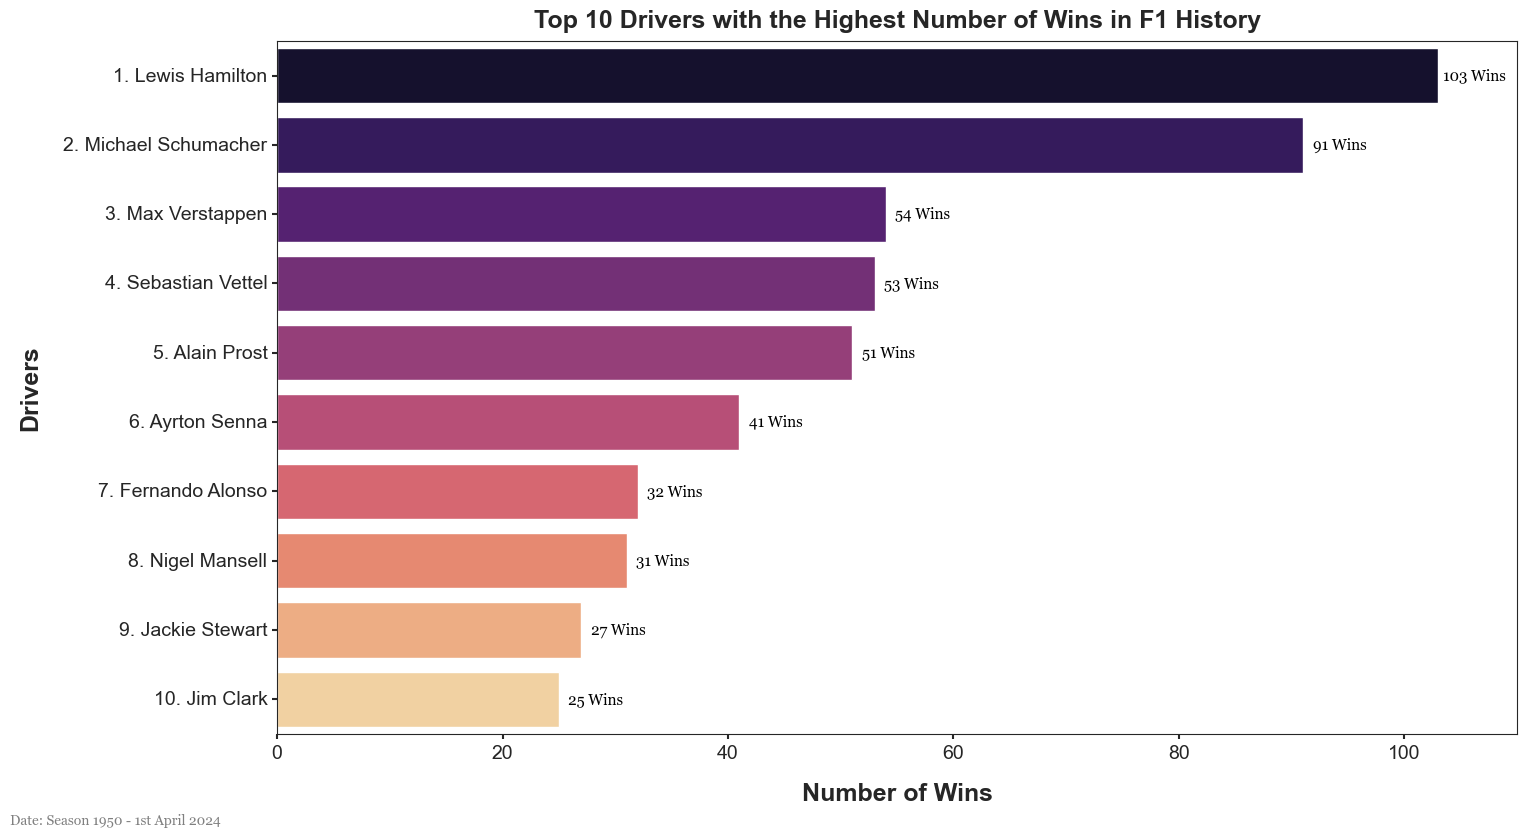

In [11]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.rc('font', family='Georgia')

# Build the Barplot
df = df_total_wins_per_races_by_wins.head(10).copy()
slct_palette = "magma"
ax = sns.barplot(x='WINS', y='DRIVER', data=df, palette=slct_palette)
ax.set_title('Top 10 Drivers with the Highest Number of Wins in F1 History', fontsize=18, fontweight='bold', pad=10)
ax.set_xlabel("Number of Wins", size=18, fontweight='bold', labelpad=15)
ax.set_ylabel("Drivers", size=18, fontweight='bold', labelpad=15)
ax.set_yticklabels([f"{i+1}. {value}" for i,value in enumerate(df['DRIVER'])], va='center')
ax.tick_params(axis='x', bottom=True, labelsize=14, width=1.5)
ax.tick_params(axis='y', left=True, labelsize=14, width=1.5)
plt.xlim([0, 110])

# Display the Values on the Bars
for index, row in df_total_wins_per_races_by_wins.head(10).iterrows():
    plt.text(row['WINS'] + 3.25, index + 0.05, f"{row['WINS']} Wins", color='black', ha="center", fontdict={'fontsize': 11})

# Insert Side Note
ax.text(-5, 10.8, 'Date: Season 1950 - 1st April 2024', fontsize=10, color='gray', ha='right')

# Save the Plot
os.makedirs(dataPrscImagesFolder, exist_ok=True)
plt.savefig(os.path.join(dataPrscImagesFolder, 'top-10-drivers-most-wins.png'), dpi=300, bbox_inches='tight')

# Show the Plot
plt.show()

######
Rank based on the WINS%

In [12]:
basedOn = 'WINS%'
rank = 1
lsRank = []
df_total_wins_per_races_by_winsprct = df_total_wins_per_races.copy().sort_values(by=[basedOn], ascending=False)
for index, row in df_total_wins_per_races_by_winsprct.iterrows():
    if (index > 0 and row[basedOn] != df_total_wins_per_races_by_winsprct.iloc[index - 1][basedOn]):
        rank += 1
    lsRank.append(rank)
    
df_total_wins_per_races_by_winsprct['RANK'] = lsRank
df_total_wins_per_races_by_winsprct.head(15)

,DRIVER,WINS,N_RACES,N_SEASONS,WINS%,RANK
84,Lee Wallard,1,2,2,50.0,2
11,Juan Fangio,24,54,8,44.44,3
67,Bill Vukovich,2,5,5,40.0,4
23,Alberto Ascari,13,34,6,38.24,5
9,Jim Clark,25,73,9,34.25,6
0,Lewis Hamilton,103,332,17,31.02,6
1,Michael Schumacher,91,308,19,29.55,7
2,Max Verstappen,54,185,9,29.19,8
8,Jackie Stewart,27,100,9,27.0,9
5,Ayrton Senna,41,162,11,25.31,10


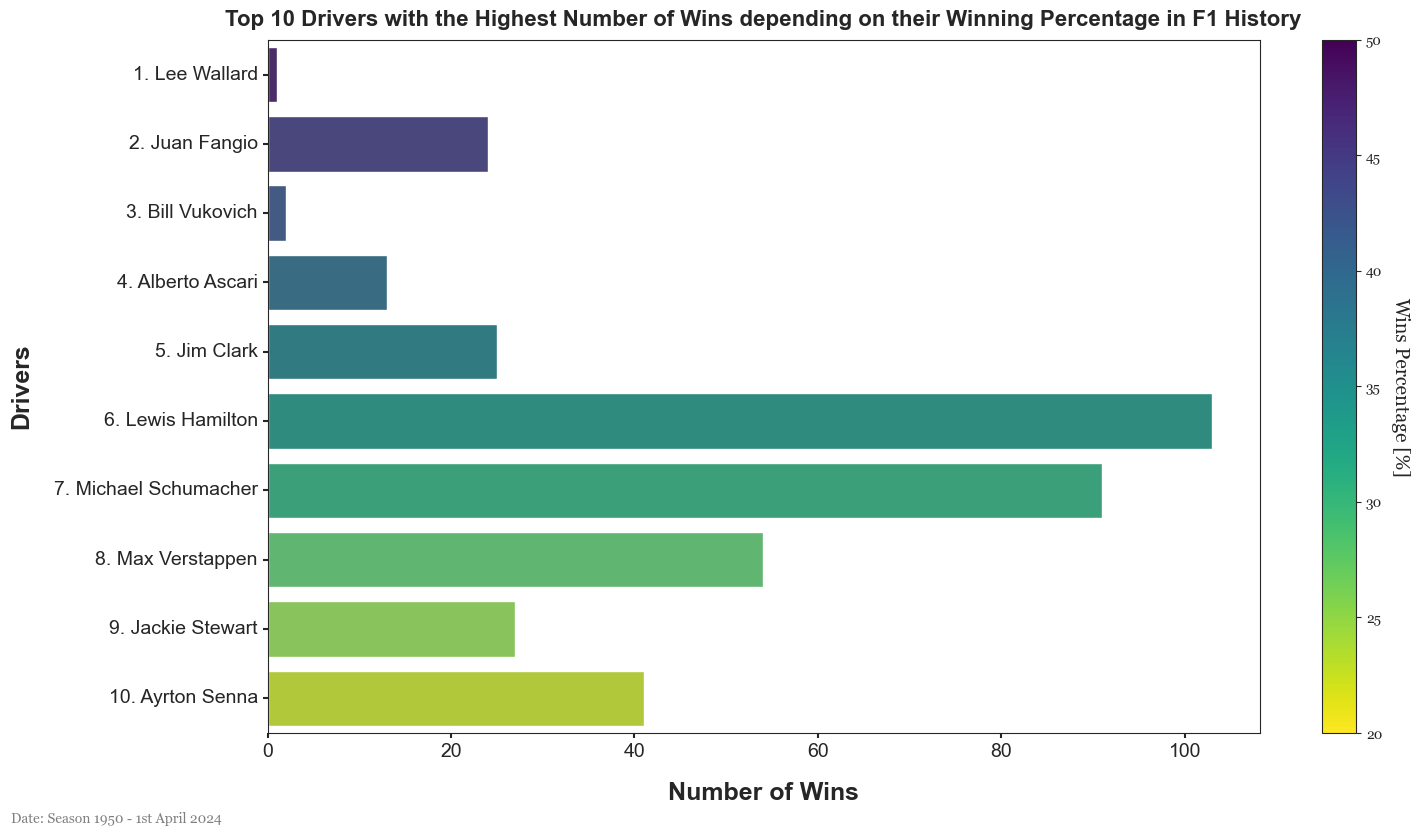

In [13]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.rc('font', family='Georgia')

# Build the Barplot
df = df_total_wins_per_races_by_winsprct.head(10).copy()
slct_palette = "viridis"
ax = sns.barplot(x='WINS', y='DRIVER', data=df, palette=slct_palette)
ax.set_title('Top 10 Drivers with the Highest Number of Wins depending on their Winning Percentage in F1 History', fontsize=16, fontweight='bold', pad=10)
ax.set_xlabel("Number of Wins", size=18, fontweight='bold', labelpad=15)
ax.set_ylabel("Drivers", size=18, fontweight='bold', labelpad=15)
ax.set_yticklabels([f"{i+1}. {value}" for i,value in enumerate(df['DRIVER'])], va='center')
ax.tick_params(axis='x', bottom=True, labelsize=14, width=1.5)
ax.tick_params(axis='y', left=True, labelsize=14, width=1.5)

# Insert Side Note
ax.text(-5, 10.8, 'Date: Season 1950 - 1st April 2024', fontsize=10, color='gray', ha='right')

# Insert Colorbar
norm = mcolors.Normalize(vmin=round(df['WINS%'].min() / 5) * 5 - 5, vmax=round(df['WINS%'].max() / 5) * 5)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=f"{slct_palette}_r", norm=norm), ax=ax)
cbar.set_label('Wins Percentage [%]', rotation=270, labelpad=20, fontsize=14, fontname='Georgia')

# Save the Plot
os.makedirs(dataPrscImagesFolder, exist_ok=True)
plt.savefig(os.path.join(dataPrscImagesFolder, 'top-10-drivers-best-wins-percentage.png'), dpi=300, bbox_inches='tight')

# Show the Plot
plt.show()

######
Rank based on the WINS% with a Minimum of 50 Races

In [14]:
basedOn = 'WINS%' 
filterOnRaces = 50
rank = 1
lsRank = []
df_total_wins_per_races_by_winsprct_mor = df_total_wins_per_races.copy().sort_values(by=[basedOn], ascending=False)
df_total_wins_per_races_by_winsprct_mor = df_total_wins_per_races_by_winsprct_mor[df_total_wins_per_races_by_winsprct_mor['N_RACES'] >= filterOnRaces].reset_index(drop=True)

for index, row in df_total_wins_per_races_by_winsprct_mor.iterrows():
    if (index > 0 and row[basedOn] != df_total_wins_per_races_by_winsprct_mor.iloc[index - 1][basedOn]):
        rank += 1
    lsRank.append(rank)
    
df_total_wins_per_races_by_winsprct_mor['RANK'] = lsRank
df_total_wins_per_races_by_winsprct_mor.head(15)

,DRIVER,WINS,N_RACES,N_SEASONS,WINS%,RANK
0,Juan Fangio,24,54,8,44.44,1
1,Jim Clark,25,73,9,34.25,2
2,Lewis Hamilton,103,332,17,31.02,3
3,Michael Schumacher,91,308,19,29.55,4
4,Max Verstappen,54,185,9,29.19,5
5,Jackie Stewart,27,100,9,27.0,6
6,Ayrton Senna,41,162,11,25.31,7
7,Alain Prost,51,202,13,25.25,8
8,Stirling Moss,16,71,11,22.54,9
9,Damon Hill,22,122,8,18.03,10


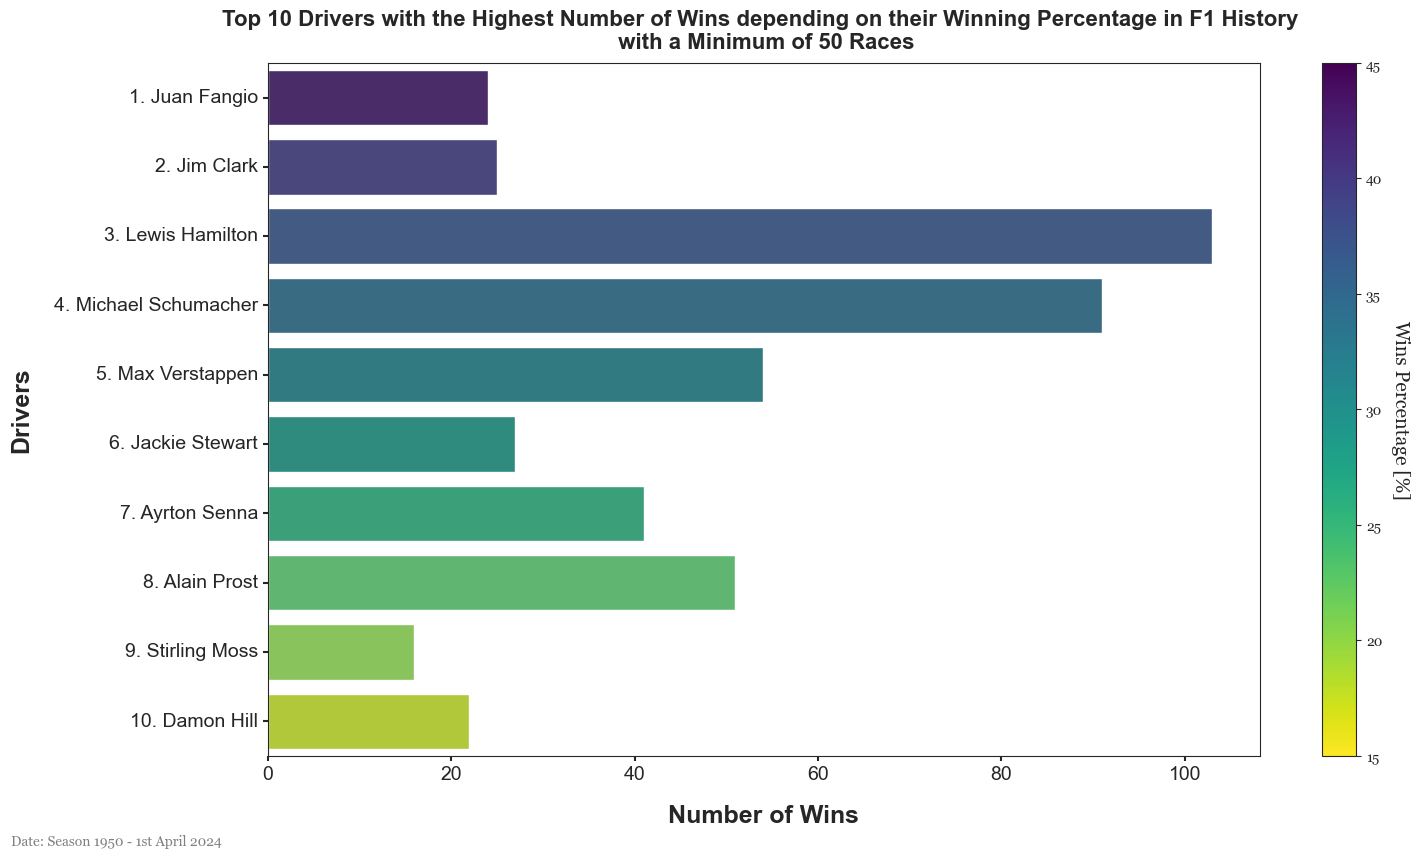

In [15]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.rc('font', family='Georgia')

# Build the Barplot
df = df_total_wins_per_races_by_winsprct_mor.head(10).copy()
slct_palette = "viridis"
ax = sns.barplot(x='WINS', y='DRIVER', data=df, palette=slct_palette)
ax.set_title(f'Top 10 Drivers with the Highest Number of Wins depending on their Winning Percentage in F1 History \n with a Minimum of {filterOnRaces} Races', fontsize=16, fontweight='bold', pad=10)
ax.set_xlabel("Number of Wins", size=18, fontweight='bold', labelpad=15)
ax.set_ylabel("Drivers", size=18, fontweight='bold', labelpad=15)
ax.set_yticklabels([f"{i+1}. {value}" for i,value in enumerate(df['DRIVER'])], va='center')
ax.tick_params(axis='x', bottom=True, labelsize=14, width=1.5)
ax.tick_params(axis='y', left=True, labelsize=14, width=1.5)

# Insert Side Note
ax.text(-5, 10.8, 'Date: Season 1950 - 1st April 2024', fontsize=10, color='gray', ha='right')

# Insert Colorbar
norm = mcolors.Normalize(vmin=round(df['WINS%'].min() / 5) * 5 - 5, vmax=round(df['WINS%'].max() / 5) * 5)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=f"{slct_palette}_r", norm=norm), ax=ax)
cbar.set_label('Wins Percentage [%]', rotation=270, labelpad=20, fontsize=14, fontname='Georgia')

# Save the Plot
os.makedirs(dataPrscImagesFolder, exist_ok=True)
plt.savefig(os.path.join(dataPrscImagesFolder, f'top-10-drivers-best-wins-percentage-min{filterOnRaces}races.png'), dpi=300, bbox_inches='tight')

# Show the Plot
plt.show()

In [16]:
# Export the Data
pathFile = os.path.join(dataProcessedFolder, 'total-wins-per-driver.csv')
exportCSV(df_winners, pathFile)

pathFile = os.path.join(dataProcessedFolder, 'total-wins-per-driver-per-races.csv')
exportCSV(df_total_wins_per_races, pathFile)

pathFile = os.path.join(dataProcessedFolder, 'rank-drivers-per-wins.csv')
exportCSV(df_total_wins_per_races_by_wins, pathFile)

pathFile = os.path.join(dataProcessedFolder, 'rank-drivers-per-winsprct.csv')
exportCSV(df_total_wins_per_races_by_winsprct, pathFile)

##### 3) Laps Led per Drivers since 1950

######
Understand the Missing Data

In [17]:
df_missing_race_per_lap_inf = pd.DataFrame() # Initialize the output dataframe
for seasonKey in dictF1.keys():  # Loop through each F1 Season
    lapInfKeys = [raceRoundKey for raceRoundKey in dictF1[seasonKey]['LAPS'].keys()]
    raceInfKeys = [raceRoundKey for raceRoundKey in dictF1[seasonKey]['RACES'].keys()]
    for lKey, rKey in zip(lapInfKeys, raceInfKeys):
        raceDone = True if datetime.datetime.strptime(dictF1[seasonKey]['RACES'][rKey]['RACE']['DATE'], '%Y-%m-%d') < datetime.datetime.now() else False
        df_round = pd.DataFrame([{'SEASON': int(seasonKey), 'ROUND': int(rKey), 'RACE_NAME': dictF1[seasonKey]['RACES'][rKey]['RACE']['NAME'], 'MISSING_LAP': False}])
        if not dictF1[seasonKey]['LAPS'][lKey] and raceDone:
            df_round['MISSING_LAP'] = True
        df_missing_race_per_lap_inf = pd.concat([df_missing_race_per_lap_inf, df_round], axis=0).reset_index(drop=True)
 
df_missing_race_per_lap_inf.sample(5)

,SEASON,ROUND,RACE_NAME,MISSING_LAP
425,1986,6,Canadian Grand Prix,True
588,1996,8,Canadian Grand Prix,False
77,1959,3,Dutch Grand Prix,True
107,1962,6,German Grand Prix,True
112,1963,2,Belgian Grand Prix,True


In [18]:
print(f"Number of Races without Lap Information: {len(df_missing_race_per_lap_inf[df_missing_race_per_lap_inf.MISSING_LAP == True])}")
print(f"Number of Races with Lap Information: {len(df_missing_race_per_lap_inf[df_missing_race_per_lap_inf.MISSING_LAP == False])}")
print()

df_first_race_lap_inf = df_missing_race_per_lap_inf[df_missing_race_per_lap_inf.MISSING_LAP == False].sort_values('MISSING_LAP', ascending=False).reset_index(drop=True).iloc[0]
print(f"First Lap Information: Season {df_first_race_lap_inf['SEASON']} / Round {df_first_race_lap_inf['ROUND']} - {df_first_race_lap_inf['RACE_NAME']}")
print()

df_missing_laps_aftfirstLI = df_missing_race_per_lap_inf[(df_missing_race_per_lap_inf['SEASON'] >= df_first_race_lap_inf.SEASON) & (df_missing_race_per_lap_inf['ROUND'] >= df_first_race_lap_inf.ROUND)]
df_missing_laps_aftfirstLI
print(f"Number of Races without Lap Information after First LI (S{df_first_race_lap_inf.SEASON}_R{df_first_race_lap_inf.ROUND}): {len(df_missing_laps_aftfirstLI[df_missing_laps_aftfirstLI.MISSING_LAP == True])}")
print(f"Number of Races with Lap Information after First LI (S{df_first_race_lap_inf.SEASON}_R{df_first_race_lap_inf.ROUND}): {len(df_missing_laps_aftfirstLI[df_missing_laps_aftfirstLI.MISSING_LAP == False])}")
print(f"Observation: {len(df_missing_laps_aftfirstLI[df_missing_laps_aftfirstLI.MISSING_LAP == True])} Missing Lap Information out of {len(df_missing_laps_aftfirstLI)}")
print(f"Conclusion: We must take into account the Lap Information from Season {df_first_race_lap_inf.SEASON}")

Number of Races without Lap Information: 581
Number of Races with Lap Information: 520

First Lap Information: Season 1996 / Round 1 - Australian Grand Prix

Number of Races without Lap Information after First LI (S1996_R1): 0
Number of Races with Lap Information after First LI (S1996_R1): 520
Observation: 0 Missing Lap Information out of 520
Conclusion: We must take into account the Lap Information from Season 1996


######
Construct the LAP Information DataFrame from FLI (First Lap Information)

In [19]:
df_lap_inf = pd.DataFrame() # Initialize the output dataframe
lst_lap_inf = []
for seasonKey in dictF1.keys():  # Loop through each F1 Season
    if int(seasonKey) < int(df_first_race_lap_inf.SEASON):
        continue 
    lapInfKeys = [raceRoundKey for raceRoundKey in dictF1[seasonKey]['LAPS'].keys()]
    raceInfKeys = [raceRoundKey for raceRoundKey in dictF1[seasonKey]['RACES'].keys()]
    for lKey, rKey in zip(lapInfKeys, raceInfKeys):
        raceDone = True if datetime.datetime.strptime(dictF1[seasonKey]['RACES'][rKey]['RACE']['DATE'], '%Y-%m-%d') < datetime.datetime.now() else False
        if not dictF1[seasonKey]['LAPS'][lKey] and raceDone:  # Ensure the LAP Information exists and the race is done
            continue
        for lapKey in dictF1[seasonKey]['LAPS'][lKey].keys():
            for driverKey in dictF1[seasonKey]['LAPS'][lKey][lapKey].keys():
                lst_lap_inf.append({'SEASON': int(seasonKey), 'ROUND': int(rKey), 'RACE_NAME': dictF1[seasonKey]['RACES'][rKey]['RACE']['NAME'],
                                    'LAP': int(lapKey), 'DRIVER': f"{dictF1[seasonKey]['DRIVERS'][driverKey]['FIRST_NAME']} {dictF1[seasonKey]['DRIVERS'][driverKey]['LAST_NAME']}", 
                                    'POSITION': dictF1[seasonKey]['LAPS'][lKey][lapKey][driverKey]['POSITION'], 'TIME': dictF1[seasonKey]['LAPS'][lKey][lapKey][driverKey]['TIME']}) 

df_lap_inf = pd.DataFrame.from_records(lst_lap_inf).sort_values(by=["SEASON", "ROUND", "LAP"]).reset_index(drop=True)
df_lap_inf['SR'] = df_lap_inf['SEASON'].astype(str) + '-' + df_lap_inf['ROUND'].astype(str)
df_lap_inf['SRL'] = df_lap_inf['SEASON'].astype(str) + '-' + df_lap_inf['ROUND'].astype(str) + '-' + df_lap_inf['LAP'].astype(str)
df_lap_inf.sample(5)

,SEASON,ROUND,RACE_NAME,LAP,DRIVER,POSITION,TIME,SR,SRL
467370,2022,16,Italian Grand Prix,29,Mick Schumacher,9,1:27.652,2022-16,2022-16-29
408542,2019,14,Italian Grand Prix,42,Lance Stroll,12,1:26.899,2019-14,2019-14-42
212365,2009,6,Monaco Grand Prix,30,Kazuki Nakajima,8,1:17.160,2009-6,2009-6-30
49035,1999,6,Canadian Grand Prix,50,Eddie Irvine,6,1:23.471,1999-6,1999-6-50
59357,2000,2,Brazilian Grand Prix,13,Jos Verstappen,7,1:17.908,2000-2,2000-2-13


In [20]:
# Export the Data
pathFile = os.path.join(dataProcessedFolder, 'laps-drivers-information-from1996.csv')
exportCSV(df_winners, pathFile)

In [21]:
print(f"Number of Observations: {len(df_lap_inf)}")
print(f"Number of Unique Seasons: {len(df_lap_inf['SEASON'].unique())}")
print(f"Number of Unique Races: {len(df_lap_inf['SR'].unique())}")
print(f"Number of Unique Laps: {len(df_lap_inf['SRL'].unique())}")

Number of Observations: 494685
Number of Unique Seasons: 28
Number of Unique Races: 520
Number of Unique Laps: 27791


######
Construct the LAP Led Information DataFrame from LLI (Laps Led Information)

In [147]:
lst_lap_led = []
for dLI in df_lap_inf.to_dict(orient='records'):
    if str(dLI['POSITION']) == '1':
        lst_lap_led.append(dLI)
df_lap_led = pd.DataFrame.from_records(lst_lap_led).groupby(['DRIVER']).size().sort_values(ascending=False).to_frame('LAPS_LEAD').reset_index()

In [148]:
df_lap_led.head(10)

,DRIVER,LAPS_LEAD
0,Lewis Hamilton,4708
1,Michael Schumacher,3512
2,Sebastian Vettel,2979
3,Max Verstappen,2372
4,Fernando Alonso,1477
5,Mika Häkkinen,1303
6,Nico Rosberg,1288
7,Kimi Räikkönen,1197
8,Felipe Massa,848
9,Rubens Barrichello,799


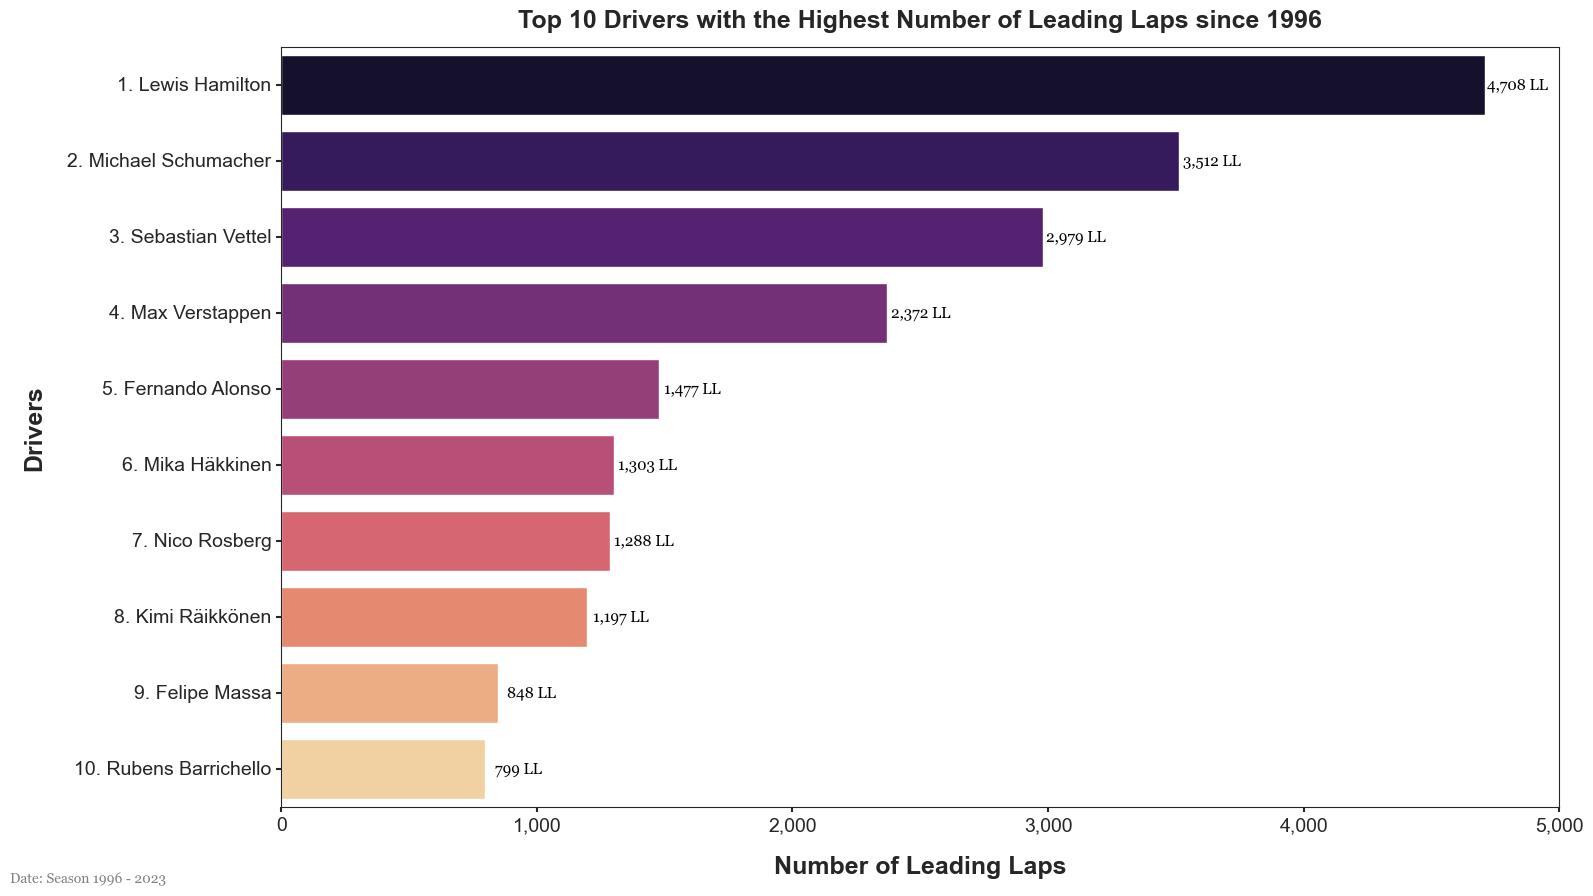

In [23]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.rc('font', family='Georgia')

# Build the Barplot
df = df_lap_led.head(10).copy()
slct_palette = "magma"
ax = sns.barplot(x='LAPS_LEAD', y='DRIVER', data=df, palette=slct_palette)
ax.set_title('Top 10 Drivers with the Highest Number of Leading Laps since 1996\n', fontsize=18, fontweight='bold', pad=-5)
ax.set_xlabel("Number of Leading Laps", size=18, fontweight='bold', labelpad=15)
ax.set_ylabel("Drivers", size=18, fontweight='bold', labelpad=15)
ax.set_yticklabels([f"{i+1}. {value}" for i,value in enumerate(df['DRIVER'])], va='center')

ax.set_xticks(range(0, (int((max(df['LAPS_LEAD'])+500)/1000) * 1000 + 1), 1000))
ax.set_xticklabels([transformInteger_intoStr(value) for value in range(0, (int((max(df['LAPS_LEAD'])+500)/1000) * 1000 + 1), 1000)])
ax.tick_params(axis='x', bottom=True, labelsize=14, width=1.5)
ax.tick_params(axis='y', left=True, labelsize=14, width=1.5)
plt.xlim([0, 5000])

# Display the Values on the Bars
for index, row in df.iterrows():
    plt.text(row['LAPS_LEAD'] + 130, index + 0.05, f"{transformInteger_intoStr(row['LAPS_LEAD'])} LL", color='black', ha="center", fontdict={'fontsize': 11})

# Insert Side Note
ax.text(-450, 10.5, 'Date: Season 1996 - 2023', fontsize=10, color='gray', ha='right')

# Tight Layout
plt.tight_layout()

# Save the Plot
os.makedirs(dataPrscImagesFolder, exist_ok=True)
plt.savefig(os.path.join(dataPrscImagesFolder, f'top-10-drivers-most-leading-laps-from1996.png'), dpi=300, bbox_inches='tight')

# Show the Plot
plt.show()

##### 4) Laps Led per Drivers against Driver in the same Team

######
Construct the TEAM MATE Information DataFrame

In [24]:
lst_drivers_constructors = []
for seasonKey in dictF1.keys():  # Loop through each F1 Season
    for raceRoundKey in dictF1[seasonKey]['RESULTS'].keys():
        for driverKey in dictF1[seasonKey]['RESULTS'][raceRoundKey].keys():
            raceResult = dictF1[seasonKey]['RESULTS'][raceRoundKey]
            lst_drivers_constructors.append({
                'DRIVER': f"{dictF1[seasonKey]['DRIVERS'][raceResult[str(driverKey)]['DRIVER_ID']]['FIRST_NAME']} {dictF1[seasonKey]['DRIVERS'][raceResult[str(driverKey)]['DRIVER_ID']]['LAST_NAME']}",
                'CONSTRUCTOR': dictF1[seasonKey]['CONSTRUCTORS'][raceResult[str(driverKey)]['CONSTRUCTOR_ID']]['NAME'],
                'SEASON': int(seasonKey),
                'ROUND': int(raceRoundKey),
                'POSITION': int(driverKey),
                'GRID_POSITION': dictF1[seasonKey]['RESULTS'][raceRoundKey][driverKey]['GRID_POSITION'],
            })

df_drivers_constructors = pd.DataFrame.from_records(lst_drivers_constructors)
df_drivers_constructors.sample(5)

,DRIVER,CONSTRUCTOR,SEASON,ROUND,POSITION,GRID_POSITION
10116,Eddie Cheever,Alfa Romeo,1985,7,10,18
24905,Esteban Ocon,Alpine F1 Team,2021,4,9,5
18924,Fernando Alonso,Renault,2006,10,5,5
19298,Felipe Massa,Ferrari,2007,9,5,4
8272,Derek Daly,March,1981,3,27,0


In [25]:
df_drivers_constructors[(df_drivers_constructors.SEASON==1982) & (df_drivers_constructors.CONSTRUCTOR=='Ferrari')]['DRIVER'].unique().tolist()

['Didier Pironi', 'Gilles Villeneuve', 'Patrick Tambay', 'Mario Andretti']

In [26]:
# Group by season and aggregate teammates
df_teams = df_drivers_constructors.groupby(['SEASON', 'ROUND', 'CONSTRUCTOR'])['DRIVER'].apply(list).reset_index(name='TEAMS')
lst_teammates = []
for index, row in df_teams.iterrows():
    for teammate in row['TEAMS']:
        lst_teammates.append({'SEASON': row['SEASON'], 'ROUND': row['ROUND'], 'CONSTRUCTOR': row['CONSTRUCTOR'], 'DRIVER': teammate, 'TEAMMATES': [teammate_ for teammate_ in row['TEAMS'] if teammate_ != teammate]})

df_teammates = pd.DataFrame.from_records(lst_teammates)
df_teammates.sample(5)

,SEASON,ROUND,CONSTRUCTOR,DRIVER,TEAMMATES
6780,1977,12,Team Lotus,Gunnar Nilsson,[Mario Andretti]
4601,1972,2,Tyrrell,Jackie Stewart,[François Cevert]
23625,2017,19,Mercedes,Valtteri Bottas,[Lewis Hamilton]
24194,2019,6,Toro Rosso,Alexander Albon,[Daniil Kvyat]
23006,2016,10,Red Bull,Daniel Ricciardo,[Max Verstappen]


In [27]:
# Export the Data
pathFile = os.path.join(dataProcessedFolder, 'teammates-per-season-and-races.csv')
exportCSV(df_teammates, pathFile)

In [28]:
set(list(itertools.chain(*df_teammates[df_teammates.DRIVER == 'Carlos Sainz']['TEAMMATES'].tolist())))
df_teammates[(df_teammates['DRIVER'] == 'Carlos Sainz') & (df_teammates['TEAMMATES'].apply(lambda x: 'Pierre Gasly' in x))]

,SEASON,ROUND,CONSTRUCTOR,DRIVER,TEAMMATES
23554,2017,15,Toro Rosso,Carlos Sainz,[Pierre Gasly]
23574,2017,16,Toro Rosso,Carlos Sainz,[Pierre Gasly]


In [29]:
len(df_teammates[df_teammates.SEASON >= 1996].to_dict(orient='records'))

11017

In [30]:
def beat_teammate(row):
    teammates = row.groupby('DRIVER')['POSITION'].min()
    return (row['POSITION'] < teammates[row['DRIVER']], row['POSITION'] > teammates[row['DRIVER']])


In [31]:
lst_info_tm = []
import time
initT = time.time()
for i, rowTM in enumerate(df_teammates[df_teammates.SEASON >= 1996].to_dict(orient='records')):
    if i % 100 == 0: 
        print(f"Processing {i+1}/{len(df_teammates[df_teammates.SEASON >= 1996].to_dict(orient='records'))} - Time: {round(time.time() - initT, 2)}s")
        
    season, race, driver, teammate = rowTM['SEASON'], rowTM['ROUND'], rowTM['DRIVER'], rowTM['TEAMMATES']
    df_temp_laps = df_lap_inf[(df_lap_inf['SEASON'] == season) & (df_lap_inf['ROUND'] == race)]
    
    df_temp_laps = (df_temp_laps[df_temp_laps.DRIVER.isin(itertools.chain(*[[driver], teammate]))])
    
    # brea
    for lap in df_temp_laps['LAP']:
        ls_lap_tm = []
        if df_temp_laps[(df_temp_laps['DRIVER'] == driver) & (df_temp_laps['LAP'] == lap)].empty:
            driverPosition = math.inf
        else:
            driverPosition = df_temp_laps[(df_temp_laps['DRIVER'] == driver) & (df_temp_laps['LAP'] == lap)]['POSITION'].values[0]
        # if not driverPosition:
            
        for teammate_ in teammate:
            if df_temp_laps[(df_temp_laps['DRIVER'] == teammate_) & (df_temp_laps['LAP'] == lap)].empty:
                ls_lap_tm.append({'TEAMMATE': None, 'DRIVER_POSITION': driverPosition, 'TEAMMATE_POSITION': math.inf, 'IS_BETTER': True})
            else:    
                teammatePosition = df_temp_laps[(df_temp_laps['DRIVER'] == teammate_) & (df_temp_laps['LAP'] == lap)]['POSITION'].values[0]
                isBetter = True if float(driverPosition) < float(teammatePosition) else False
                ls_lap_tm.append({'TEAMMATE': teammate_, 'DRIVER_POSITION': driverPosition, 'TEAMMATE_POSITION': teammatePosition, 'IS_BETTER': isBetter})
        beat_all_teammates = True if all([d['IS_BETTER'] for d in ls_lap_tm]) else False
        lst_info_tm.append({'SEASON': season, 'ROUND': race, 'DRIVER': driver, 'LAP': lap, 'BEAT_ALL_TEAMMATES': beat_all_teammates, 'INFORMATION': ls_lap_tm})
    dictInfo = {'SEASON': season, 'ROUND': race, 'DRIVER': driver}

df_lap_led_teammates = pd.DataFrame.from_records(lst_info_tm).sort_values(by=["SEASON", "ROUND", "LAP", "DRIVER"]).drop_duplicates(subset=['SEASON', 'ROUND', 'DRIVER', 'LAP'], keep='first', inplace=True).reset_index(drop=True)
df_lap_led_teammates['SR'] = df_lap_led_teammates['SEASON'].astype(str) + '-' + df_lap_led_teammates['ROUND'].astype(str)
df_lap_led_teammates['SRL'] = df_lap_led_teammates['SEASON'].astype(str) + '-' + df_lap_led_teammates['ROUND'].astype(str) + '-' + df_lap_led_teammates['LAP'].astype(str)
df_lap_led_teammates.sample(5)

Processing 1/11017 - Time: 0.13s
Processing 101/11017 - Time: 12.0s
Processing 201/11017 - Time: 21.97s
Processing 301/11017 - Time: 31.65s
Processing 401/11017 - Time: 43.74s
Processing 501/11017 - Time: 54.97s
Processing 601/11017 - Time: 69.12s
Processing 701/11017 - Time: 85.32s
Processing 801/11017 - Time: 98.06s
Processing 901/11017 - Time: 111.66s
Processing 1001/11017 - Time: 122.94s
Processing 1101/11017 - Time: 135.02s
Processing 1201/11017 - Time: 148.39s
Processing 1301/11017 - Time: 161.32s
Processing 1401/11017 - Time: 175.52s
Processing 1501/11017 - Time: 189.14s
Processing 1601/11017 - Time: 203.78s
Processing 1701/11017 - Time: 218.05s
Processing 1801/11017 - Time: 230.71s
Processing 1901/11017 - Time: 243.63s
Processing 2001/11017 - Time: 258.31s
Processing 2101/11017 - Time: 270.52s
Processing 2201/11017 - Time: 282.24s
Processing 2301/11017 - Time: 295.57s
Processing 2401/11017 - Time: 308.93s
Processing 2501/11017 - Time: 322.81s
Processing 2601/11017 - Time: 335.1

,SEASON,ROUND,DRIVER,LAP,BEAT_ALL_TEAMMATES,INFORMATION
200078,2002,11,Juan Pablo Montoya,17,True,"[{'TEAMMATE': 'Ralf Schumacher', 'DRIVER_POSIT..."
459349,2010,7,Vitaly Petrov,19,False,"[{'TEAMMATE': 'Robert Kubica', 'DRIVER_POSITIO..."
327855,2006,9,Franck Montagny,37,False,"[{'TEAMMATE': 'Takuma Sato', 'DRIVER_POSITION'..."
299308,2005,13,Nick Heidfeld,50,True,"[{'TEAMMATE': 'Mark Webber', 'DRIVER_POSITION'..."
749555,2017,20,Brendon Hartley,17,True,"[{'TEAMMATE': 'Pierre Gasly', 'DRIVER_POSITION..."


In [50]:
df_lap_led_teammates = pd.DataFrame.from_records(lst_info_tm).sort_values(by=["SEASON", "ROUND", "LAP", "DRIVER"], ascending=True).reset_index(drop=True)

In [71]:
# Export the Data
pathFile = os.path.join(dataProcessedFolder, 'laps-led-teammates-information-from1996.csv')
exportCSV(df_lap_led_teammates, pathFile)

In [72]:
print(f"Number of Observations: {len(df_lap_led_teammates)}")
print(f"Number of Unique Drivers: {len(df_lap_led_teammates['DRIVER'].unique())}")
print(f"Number of Unique Seasons: {len(df_lap_led_teammates['SEASON'].unique())}")
print(f"Number of Unique Races: {len(df_lap_led_teammates['SR'].unique())}")
print(f"Number of Unique Laps: {len(df_lap_led_teammates['SRL'].unique())}")

Number of Observations: 558393
Number of Unique Drivers: 140
Number of Unique Seasons: 28
Number of Unique Races: 520
Number of Unique Laps: 27791


In [126]:
lst_lap_led_teammate = []
for driver in df_lap_led_teammates['DRIVER'].unique():
    df_driver_tm = df_lap_led_teammates[(df_lap_led_teammates['DRIVER'] == driver)]
    driver_tm_nseason, driver_tm_nround, driver_tm_nlap = len(df_driver_tm.SEASON.unique()), len(df_driver_tm.SR.unique()), len(df_driver_tm.SRL.unique())
    lst_lap_led_teammate.append({'DRIVER': driver, 'N_SEASONS': driver_tm_nseason, 'N_RACES': driver_tm_nround, 'N_LAPS': driver_tm_nlap, 'N_LAP_LED': len(df_driver_tm[df_driver_tm.BEAT_ALL_TEAMMATES == True]), })


df_lap_led_on_teammate = pd.DataFrame.from_records(lst_lap_led_teammate).sort_values(by='N_LAP_LED', ascending=False).reset_index(drop=True)
df_lap_led_on_teammate["LAP_LED%"] = round((df_lap_led_on_teammate['N_LAP_LED'] / df_lap_led_on_teammate['N_LAPS']) * 100, 2)
df_lap_led_on_teammate.sample(5)

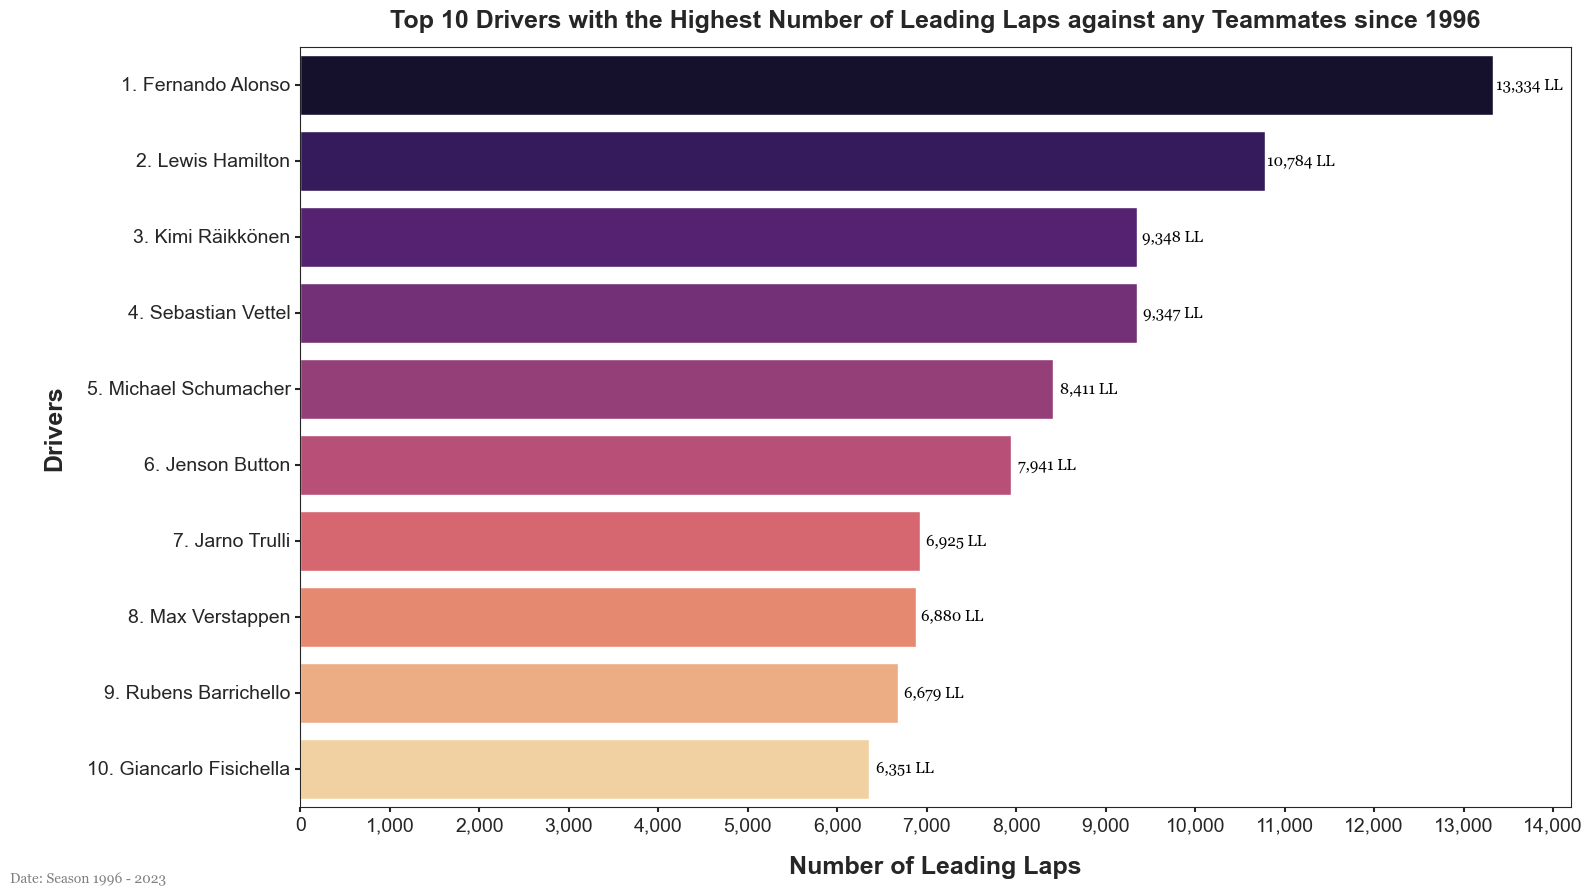

In [141]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.rc('font', family='Georgia')

# Build the Barplot
df = df_lap_led_on_teammate.head(10).copy()
slct_palette = "magma"
ax = sns.barplot(x='N_LAP_LED', y='DRIVER', data=df, palette=slct_palette)
ax.set_title('Top 10 Drivers with the Highest Number of Leading Laps against any Teammates since 1996\n', fontsize=18, fontweight='bold', pad=-5)
ax.set_xlabel("Number of Leading Laps", size=18, fontweight='bold', labelpad=15)
ax.set_ylabel("Drivers", size=18, fontweight='bold', labelpad=15)
ax.set_yticklabels([f"{i+1}. {value}" for i,value in enumerate(df['DRIVER'])], va='center')

ax.set_xticks(range(0, (math.ceil((max(df['N_LAP_LED'])+500)/1000) * 1000 + 1), 1000))
ax.set_xticklabels([transformInteger_intoStr(value) for value in range(0, (math.ceil((max(df['N_LAP_LED'])+500)/1000) * 1000 + 1), 1000)])
ax.tick_params(axis='x', bottom=True, labelsize=14, width=1.5)
ax.tick_params(axis='y', left=True, labelsize=14, width=1.5)
plt.xlim([0, 14200])

# Display the Values on the Bars
for index, row in df.iterrows():
    plt.text(row['N_LAP_LED'] + 400, index + 0.05, f"{transformInteger_intoStr(row['N_LAP_LED'])} LL", color='black', ha="center", fontdict={'fontsize': 11})

# Insert Side Note
ax.text(-1500, 10.5, 'Date: Season 1996 - 2023', fontsize=10, color='gray', ha='right')

# Tight Layout
plt.tight_layout()

# Save the Plot
os.makedirs(dataPrscImagesFolder, exist_ok=True)
plt.savefig(os.path.join(dataPrscImagesFolder, f'top-10-drivers-most-leading-laps-against-teammates-from1996.png'), dpi=300, bbox_inches='tight')

# Show the Plot
plt.show()

In [131]:
df_lap_led_on_prct_teammate = df_lap_led_on_teammate[df_lap_led_on_teammate.N_RACES >= 50].copy()
df_lap_led_on_prct_teammate = df_lap_led_on_prct_teammate.sort_values(by='LAP_LED%', ascending=False)

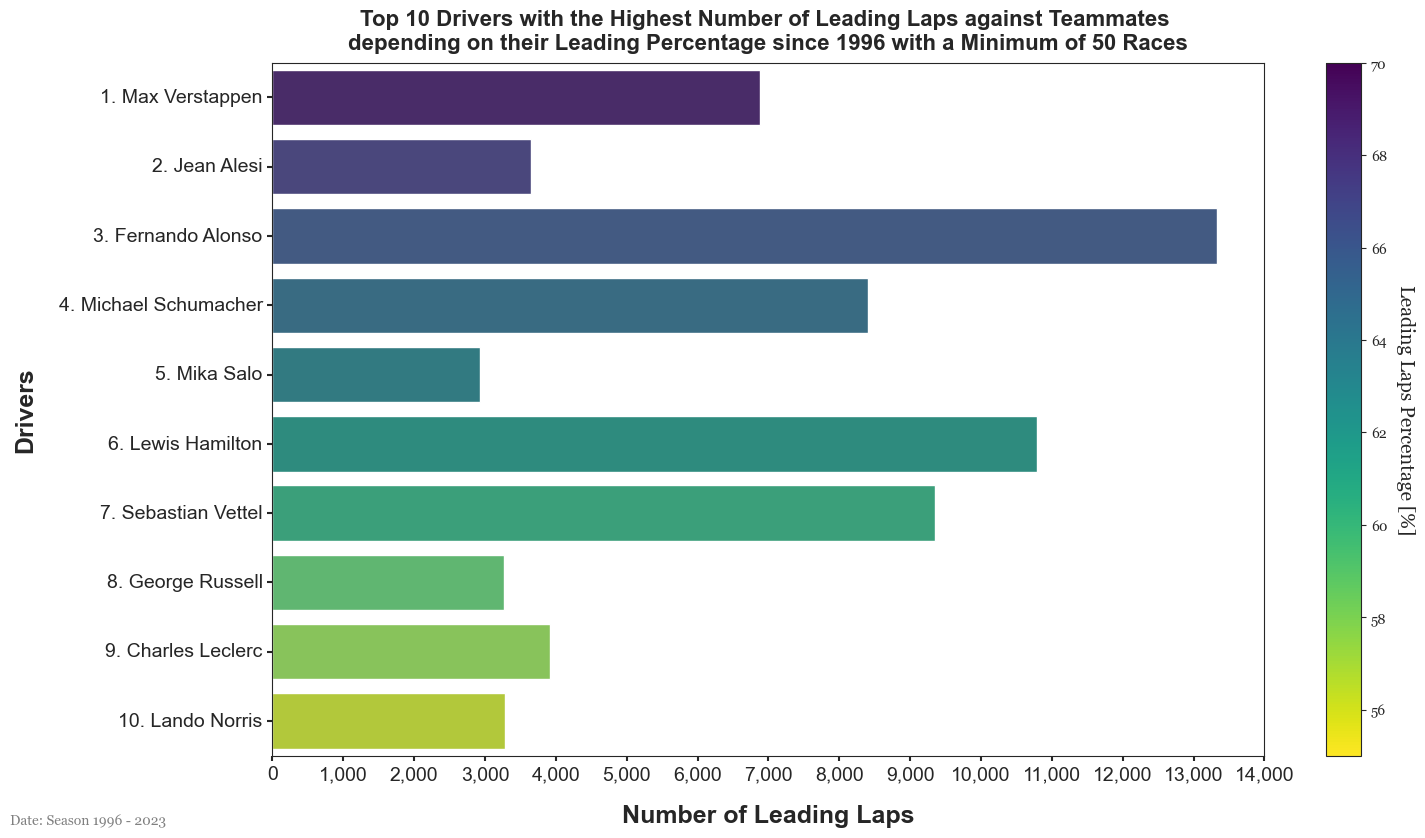

In [144]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.rc('font', family='Georgia')

# Build the Barplot
df = df_lap_led_on_prct_teammate.head(10).copy()
slct_palette = "viridis"
ax = sns.barplot(x='N_LAP_LED', y='DRIVER', data=df, palette=slct_palette)
ax.set_title(f'Top 10 Drivers with the Highest Number of Leading Laps against Teammates \ndepending on their Leading Percentage since 1996 with a Minimum of {filterOnRaces} Races', fontsize=16, fontweight='bold', pad=10)
ax.set_xlabel("Number of Leading Laps", size=18, fontweight='bold', labelpad=15)
ax.set_ylabel("Drivers", size=18, fontweight='bold', labelpad=15)
ax.set_yticklabels([f"{i+1}. {value}" for i,value in enumerate(df['DRIVER'])], va='center')

ax.set_xticks(range(0, (math.ceil((max(df['N_LAP_LED'])+500)/1000) * 1000 + 1), 1000))
ax.set_xticklabels([transformInteger_intoStr(value) for value in range(0, (math.ceil((max(df['N_LAP_LED'])+500)/1000) * 1000 + 1), 1000)])
ax.tick_params(axis='x', bottom=True, labelsize=14, width=1.5)
ax.tick_params(axis='y', left=True, labelsize=14, width=1.5)
plt.xlim([0, 14000])

# Insert Side Note
ax.text(-1500, 10.5, 'Date: Season 1996 - 2023', fontsize=10, color='gray', ha='right')

# Insert Colorbar
norm = mcolors.Normalize(vmin=round(df['LAP_LED%'].min() / 5) * 5 - 5, vmax=round(df['LAP_LED%'].max() / 5) * 5)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=f"{slct_palette}_r", norm=norm), ax=ax)
cbar.set_label('Leading Laps Percentage [%]', rotation=270, labelpad=20, fontsize=14, fontname='Georgia')

# Save the Plot
os.makedirs(dataPrscImagesFolder, exist_ok=True)
plt.savefig(os.path.join(dataPrscImagesFolder, f'top-10-drivers-most-leading-laps-percentage-min{filterOnRaces}race.png'), dpi=300, bbox_inches='tight')

# Show the Plot
plt.show()